In [16]:
import torch 
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt 
from tqdm import tqdm

device="cuda" if torch.cuda.is_available() else "cpu"

print(torch.__version__)
print(torchvision.__version__)

2.0.0
0.15.0


In [17]:
from pathlib import Path
from helper_functions import walk_through_dir

data_path=Path("data/")
image_path = data_path / "militaryvsother"
walk_through_dir(image_path)

There are 3 directories and 0 images in 'data\militaryvsother'.
There are 2 directories and 0 images in 'data\militaryvsother\test'.
There are 0 directories and 1281 images in 'data\militaryvsother\test\millitary'.
There are 0 directories and 1511 images in 'data\militaryvsother\test\other'.
There are 2 directories and 0 images in 'data\militaryvsother\train'.
There are 0 directories and 5125 images in 'data\militaryvsother\train\millitary'.
There are 0 directories and 6045 images in 'data\militaryvsother\train\other'.
There are 2 directories and 0 images in 'data\militaryvsother\validation'.
There are 0 directories and 1602 images in 'data\militaryvsother\validation\millitary'.
There are 0 directories and 1889 images in 'data\militaryvsother\validation\other'.


In [18]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/militaryvsother/train'),
 WindowsPath('data/militaryvsother/test'))

Random image path: data\militaryvsother\test\other\other_0_6166.jpeg
Image class: other
Image height: 256
Image width: 256


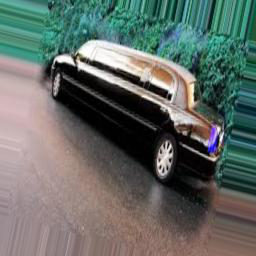

In [19]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpeg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)

print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

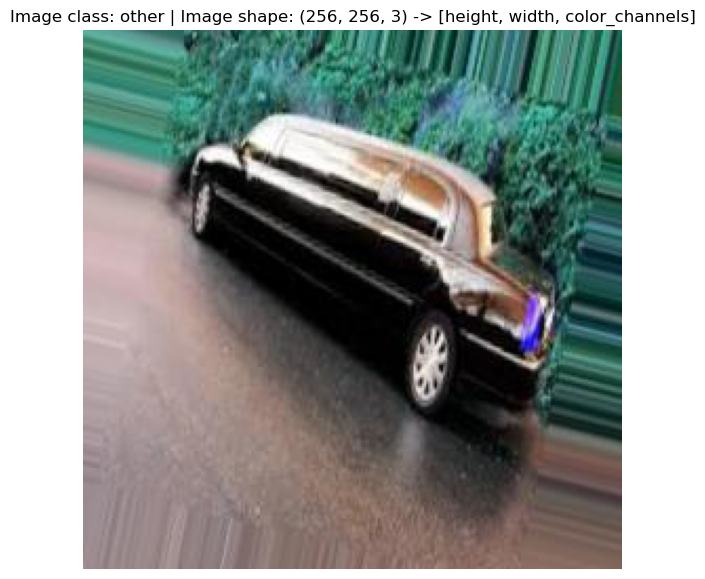

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);


In [21]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

data_transformer=transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

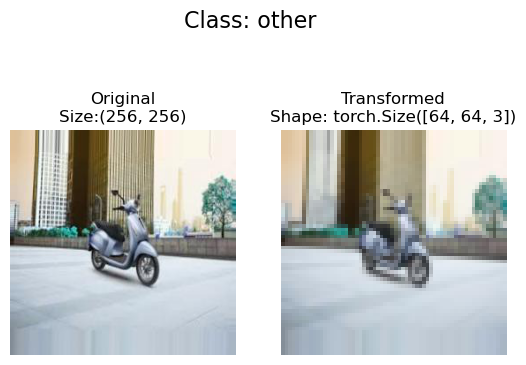

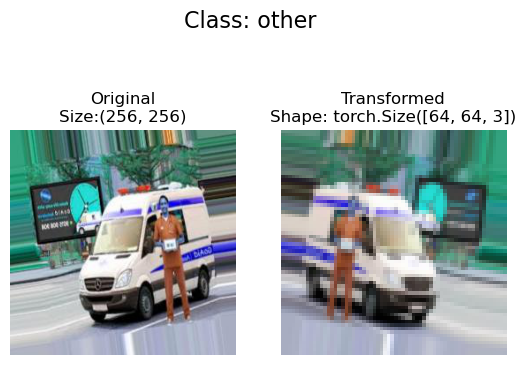

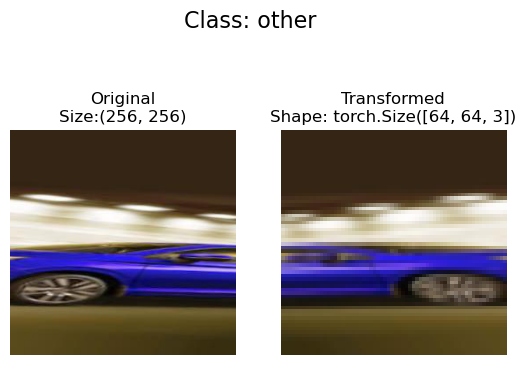

In [22]:
from helper_functions import plot_transformed_images

plot_transformed_images(image_path_list,transform=data_transformer)

In [23]:
from torchvision import datasets

train_data=datasets.ImageFolder(root=train_dir,
                                transform=data_transformer,
                                target_transform=None)

test_data=datasets.ImageFolder(root=test_dir,
                               transform=data_transformer)
print(f"Train Data:\n{train_data}\nTest Data:\n{test_data}")

Train Data:
Dataset ImageFolder
    Number of datapoints: 11170
    Root location: data\militaryvsother\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test Data:
Dataset ImageFolder
    Number of datapoints: 2792
    Root location: data\militaryvsother\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [24]:
#train data size, test data size and percentage of test to train
len(train_data),len(test_data),(len(test_data)/(len(train_data)+len(test_data))*100)

(11170, 2792, 19.997135080933965)

In [25]:
classes=train_data.classes
class_dict=train_data.class_to_idx
classes,class_dict

(['millitary', 'other'], {'millitary': 0, 'other': 1})

In [26]:
from torch.utils.data import DataLoader
import os
BATCH_SIZE=128
NUM_WORKERS=os.cpu_count()

train_dataloader=DataLoader(dataset=train_data,
                            batch_size=BATCH_SIZE,
                            num_workers=NUM_WORKERS,
                            shuffle=True)


test_dataloader=DataLoader(dataset=test_data,
                           batch_size=BATCH_SIZE,
                           num_workers=NUM_WORKERS,
                           shuffle=False)
train_dataloader,test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x1e3a12c6b20>,
 <torch.utils.data.dataloader.DataLoader at 0x1e3a1135100>)

In [27]:
from helper_functions import set_seeds
set_seeds()

class MilitaryNormalClassModel(nn.Module):
    def __init__(self,
                 input_shape: int,
                 hidden_units: int,
                 output_shape: int):
        super().__init__()
        self.conv_block_1=nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1), #hyperparameters of Conv2d
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)#kernel size can also be a tuple such as (2,2)

        )
        self.conv_block_2=nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier_layer=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)#out features -> class_names
        )

    def forward(self,x:torch.tensor):
        x=self.conv_block_1(x)
        #print(f"Output shape after conv block 1: {x.shape}")
        x=self.conv_block_2(x)
        #print(f"Output shape after conv block 2: {x.shape}")
        x=self.classifier_layer(x)
        #print(f"Output shape after classifier layer: {x.shape}")
        return x

In [28]:
model_0=MilitaryNormalClassModel(input_shape=3,
                                 hidden_units=30,
                                 output_shape=len(classes)).to(device)

In [29]:
#Setup loss function eval metrics and optimizer
from helper_functions import accuracy_fn

loss_fn=nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.01)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from helper_functions import print_train_time, test_step, train_step 

from timeit import default_timer as timer


train_time_start_model_0=timer()

epochs=100

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch+1}\n-------------")
    train_step(model=model_0,
               data_loader=train_dataloader,
               loss_fn=loss_fn,
               optimizer=optimizer,
               accuracy_fn=accuracy_fn,
               device=device)
    test_step(model=model_0,
              data_loader=train_dataloader,
              loss_fn=loss_fn,
              accuracy_fn=accuracy_fn,
              device=device)
    
train_time_end_model_0=timer()
total_train_time_model_2=print_train_time(start=train_time_start_model_0,
                                          end=train_time_end_model_0,
                                          device=device)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1
-------------
Train loss: 0.68842 | Train acc: 54.08%


  1%|          | 1/100 [00:47<1:19:11, 48.00s/it]


Test loss: 0.6871, Test acc 54.2556
Epoch: 2
-------------
Train loss: 0.68649 | Train acc: 54.08%


  2%|▏         | 2/100 [01:37<1:19:48, 48.86s/it]


Test loss: 0.6853, Test acc 54.1084
Epoch: 3
-------------
Train loss: 0.68271 | Train acc: 54.01%


  3%|▎         | 3/100 [02:26<1:18:51, 48.78s/it]


Test loss: 0.6797, Test acc 56.1884
Epoch: 4
-------------
Train loss: 0.67205 | Train acc: 56.88%


  4%|▍         | 4/100 [03:14<1:18:03, 48.78s/it]


Test loss: 0.6718, Test acc 54.6144
Epoch: 5
-------------
Train loss: 0.65571 | Train acc: 61.33%


  5%|▌         | 5/100 [04:03<1:16:54, 48.57s/it]


Test loss: 0.6479, Test acc 62.6452
Epoch: 6
-------------
Train loss: 0.64534 | Train acc: 63.46%


  6%|▌         | 6/100 [04:52<1:16:42, 48.96s/it]


Test loss: 0.6550, Test acc 61.5151
Epoch: 7
-------------
Train loss: 0.63503 | Train acc: 64.63%


  7%|▋         | 7/100 [05:41<1:15:38, 48.81s/it]


Test loss: 0.6272, Test acc 65.7634
Epoch: 8
-------------
Train loss: 0.62357 | Train acc: 65.81%


  8%|▊         | 8/100 [06:28<1:14:01, 48.28s/it]


Test loss: 0.6115, Test acc 67.4993
Epoch: 9
-------------
Train loss: 0.60315 | Train acc: 68.36%


  9%|▉         | 9/100 [07:16<1:12:53, 48.06s/it]


Test loss: 0.6036, Test acc 68.4220
Epoch: 10
-------------
Train loss: 0.58366 | Train acc: 70.21%


 10%|█         | 10/100 [08:04<1:12:14, 48.16s/it]


Test loss: 0.7077, Test acc 54.0467
Epoch: 11
-------------
Train loss: 0.53935 | Train acc: 73.12%


 11%|█         | 11/100 [08:52<1:11:24, 48.14s/it]


Test loss: 0.5135, Test acc 75.9604
Epoch: 12
-------------
Train loss: 0.51011 | Train acc: 74.93%


 12%|█▏        | 12/100 [09:40<1:10:31, 48.08s/it]


Test loss: 0.4944, Test acc 76.6017
Epoch: 13
-------------
Train loss: 0.49607 | Train acc: 76.07%


 13%|█▎        | 13/100 [10:27<1:09:26, 47.89s/it]


Test loss: 0.5159, Test acc 73.6469
Epoch: 14
-------------
Train loss: 0.49197 | Train acc: 76.27%


 14%|█▍        | 14/100 [11:15<1:08:30, 47.80s/it]


Test loss: 0.4858, Test acc 77.2163
Epoch: 15
-------------
Train loss: 0.48371 | Train acc: 76.78%


 15%|█▌        | 15/100 [12:03<1:07:46, 47.85s/it]


Test loss: 0.4963, Test acc 76.9787
Epoch: 16
-------------
Train loss: 0.48516 | Train acc: 76.39%


 16%|█▌        | 16/100 [12:51<1:06:53, 47.79s/it]


Test loss: 0.5554, Test acc 71.0478
Epoch: 17
-------------
Train loss: 0.47276 | Train acc: 77.83%


 17%|█▋        | 17/100 [13:38<1:05:56, 47.67s/it]


Test loss: 0.5233, Test acc 74.6950
Epoch: 18
-------------
Train loss: 0.46985 | Train acc: 78.01%


 18%|█▊        | 18/100 [14:26<1:05:05, 47.62s/it]


Test loss: 0.4453, Test acc 79.7820
Epoch: 19
-------------
Train loss: 0.46840 | Train acc: 77.75%


 19%|█▉        | 19/100 [15:14<1:04:31, 47.80s/it]


Test loss: 0.4563, Test acc 78.4211
Epoch: 20
-------------
Train loss: 0.46672 | Train acc: 78.48%


 20%|██        | 20/100 [16:03<1:04:30, 48.39s/it]


Test loss: 0.4931, Test acc 76.0554
Epoch: 21
-------------
Train loss: 0.45551 | Train acc: 78.77%


 21%|██        | 21/100 [16:51<1:03:32, 48.26s/it]


Test loss: 0.4330, Test acc 80.8045
Epoch: 22
-------------
Train loss: 0.45550 | Train acc: 78.58%


 22%|██▏       | 22/100 [17:39<1:02:33, 48.13s/it]


Test loss: 0.4885, Test acc 75.5802
Epoch: 23
-------------
Train loss: 0.45293 | Train acc: 79.33%


 23%|██▎       | 23/100 [18:27<1:01:33, 47.96s/it]


Test loss: 0.4251, Test acc 81.2714
Epoch: 24
-------------
Train loss: 0.44169 | Train acc: 79.65%


 24%|██▍       | 24/100 [19:14<1:00:35, 47.84s/it]


Test loss: 0.4471, Test acc 80.4787
Epoch: 25
-------------
Train loss: 0.44380 | Train acc: 79.74%


 25%|██▌       | 25/100 [20:02<59:34, 47.66s/it]  


Test loss: 0.4322, Test acc 80.3257
Epoch: 26
-------------
Train loss: 0.43391 | Train acc: 80.51%


 26%|██▌       | 26/100 [20:49<58:38, 47.54s/it]


Test loss: 0.4364, Test acc 80.3434
Epoch: 27
-------------
Train loss: 0.44471 | Train acc: 79.32%


 27%|██▋       | 27/100 [21:37<57:57, 47.63s/it]


Test loss: 0.4422, Test acc 78.6613
Epoch: 28
-------------
Train loss: 0.42793 | Train acc: 80.55%


 28%|██▊       | 28/100 [22:24<57:00, 47.50s/it]


Test loss: 0.4271, Test acc 80.1800
Epoch: 29
-------------
Train loss: 0.42868 | Train acc: 80.22%


 29%|██▉       | 29/100 [23:11<56:13, 47.51s/it]


Test loss: 0.4163, Test acc 81.0563
Epoch: 30
-------------
Train loss: 0.42006 | Train acc: 81.19%


 30%|███       | 30/100 [23:59<55:22, 47.46s/it]


Test loss: 0.4234, Test acc 80.4097
Epoch: 31
-------------
Train loss: 0.42444 | Train acc: 80.68%


 31%|███       | 31/100 [24:47<54:42, 47.57s/it]


Test loss: 0.6271, Test acc 67.1175
Epoch: 32
-------------
Train loss: 0.42570 | Train acc: 80.36%


 32%|███▏      | 32/100 [25:34<53:56, 47.60s/it]


Test loss: 0.3985, Test acc 82.7253
Epoch: 33
-------------
Train loss: 0.41628 | Train acc: 81.14%


 33%|███▎      | 33/100 [26:22<53:07, 47.57s/it]


Test loss: 0.4128, Test acc 81.3403
Epoch: 34
-------------
Train loss: 0.40915 | Train acc: 81.73%


 34%|███▍      | 34/100 [27:09<52:14, 47.50s/it]


Test loss: 0.4036, Test acc 82.2610
Epoch: 35
-------------
Train loss: 0.40993 | Train acc: 81.57%


 35%|███▌      | 35/100 [27:57<51:31, 47.56s/it]


Test loss: 0.4698, Test acc 76.0335
Epoch: 36
-------------
Train loss: 0.40681 | Train acc: 81.67%


 36%|███▌      | 36/100 [28:44<50:45, 47.58s/it]


Test loss: 0.4766, Test acc 76.3839
Epoch: 37
-------------
Train loss: 0.39949 | Train acc: 82.26%


 37%|███▋      | 37/100 [29:32<49:56, 47.56s/it]


Test loss: 0.4216, Test acc 81.2740
Epoch: 38
-------------
Train loss: 0.39931 | Train acc: 82.21%


 38%|███▊      | 38/100 [30:19<49:07, 47.53s/it]


Test loss: 0.4080, Test acc 82.2636
Epoch: 39
-------------
Train loss: 0.39722 | Train acc: 81.90%


 39%|███▉      | 39/100 [31:08<48:32, 47.74s/it]


Test loss: 0.5250, Test acc 72.5664
Epoch: 40
-------------
Train loss: 0.39831 | Train acc: 82.16%


 40%|████      | 40/100 [31:56<47:46, 47.78s/it]


Test loss: 0.4132, Test acc 81.4380
Epoch: 41
-------------
Train loss: 0.38798 | Train acc: 82.87%


 41%|████      | 41/100 [32:44<47:01, 47.83s/it]


Test loss: 0.3791, Test acc 82.9650
Epoch: 42
-------------
Train loss: 0.38414 | Train acc: 83.21%


 42%|████▏     | 42/100 [33:31<46:15, 47.85s/it]


Test loss: 0.3771, Test acc 83.1953
Epoch: 43
-------------
Train loss: 0.38640 | Train acc: 82.78%


 43%|████▎     | 43/100 [34:19<45:24, 47.80s/it]


Test loss: 0.5011, Test acc 75.6382
Epoch: 44
-------------
Train loss: 0.37827 | Train acc: 83.18%


 44%|████▍     | 44/100 [35:07<44:46, 47.98s/it]


Test loss: 0.4855, Test acc 75.3055
Epoch: 45
-------------
Train loss: 0.37949 | Train acc: 83.18%


 45%|████▌     | 45/100 [35:58<44:35, 48.65s/it]


Test loss: 0.6486, Test acc 68.7176
Epoch: 46
-------------
Train loss: 0.38274 | Train acc: 83.20%


 46%|████▌     | 46/100 [36:45<43:33, 48.39s/it]


Test loss: 0.3576, Test acc 84.5672
Epoch: 47
-------------
Train loss: 0.37120 | Train acc: 83.53%


 47%|████▋     | 47/100 [37:33<42:34, 48.20s/it]


Test loss: 0.3601, Test acc 84.2345
Epoch: 48
-------------
Train loss: 0.36869 | Train acc: 83.68%


 48%|████▊     | 48/100 [38:21<41:36, 48.01s/it]


Test loss: 0.3565, Test acc 84.5740
Epoch: 49
-------------
Train loss: 0.36949 | Train acc: 83.74%


 49%|████▉     | 49/100 [39:08<40:42, 47.89s/it]


Test loss: 0.4095, Test acc 81.3999
Epoch: 50
-------------
Train loss: 0.36378 | Train acc: 83.79%


 50%|█████     | 50/100 [39:58<40:18, 48.37s/it]


Test loss: 0.3539, Test acc 84.5296
Epoch: 51
-------------
Train loss: 0.36476 | Train acc: 84.19%


 51%|█████     | 51/100 [40:48<39:57, 48.92s/it]


Test loss: 0.3840, Test acc 82.2119
Epoch: 52
-------------
Train loss: 0.36689 | Train acc: 83.53%


 52%|█████▏    | 52/100 [41:36<38:56, 48.68s/it]


Test loss: 0.3465, Test acc 84.8586
Epoch: 53
-------------
Train loss: 0.36448 | Train acc: 83.72%


 53%|█████▎    | 53/100 [42:25<38:04, 48.60s/it]


Test loss: 0.3548, Test acc 84.4163
Epoch: 54
-------------
Train loss: 0.35848 | Train acc: 84.40%


 54%|█████▍    | 54/100 [43:12<37:04, 48.36s/it]


Test loss: 0.3671, Test acc 83.0068
Epoch: 55
-------------
Train loss: 0.35756 | Train acc: 84.39%


 55%|█████▌    | 55/100 [44:01<36:12, 48.27s/it]


Test loss: 0.3505, Test acc 84.9646
Epoch: 56
-------------
Train loss: 0.35550 | Train acc: 84.42%


 56%|█████▌    | 56/100 [44:48<35:14, 48.06s/it]


Test loss: 0.3953, Test acc 81.0719
Epoch: 57
-------------
Train loss: 0.36021 | Train acc: 83.81%


 57%|█████▋    | 57/100 [45:36<34:22, 47.97s/it]


Test loss: 0.6110, Test acc 69.5762
Epoch: 58
-------------
Train loss: 0.35294 | Train acc: 84.59%


 58%|█████▊    | 58/100 [46:24<33:34, 47.97s/it]


Test loss: 0.3567, Test acc 84.7761
Epoch: 59
-------------
Train loss: 0.35037 | Train acc: 84.90%


 59%|█████▉    | 59/100 [47:12<32:44, 47.92s/it]


Test loss: 0.3535, Test acc 84.8737
Epoch: 60
-------------
Train loss: 0.34992 | Train acc: 84.63%


 60%|██████    | 60/100 [47:59<31:54, 47.87s/it]


Test loss: 0.3483, Test acc 85.2623
Epoch: 61
-------------
Train loss: 0.35118 | Train acc: 84.50%


 61%|██████    | 61/100 [48:47<31:07, 47.87s/it]


Test loss: 0.4412, Test acc 78.0843
Epoch: 62
-------------
Train loss: 0.34851 | Train acc: 84.54%


 62%|██████▏   | 62/100 [49:35<30:20, 47.90s/it]


Test loss: 0.3344, Test acc 85.6372
Epoch: 63
-------------
Train loss: 0.34239 | Train acc: 85.35%


 63%|██████▎   | 63/100 [50:24<29:42, 48.17s/it]


Test loss: 0.3748, Test acc 83.4115
Epoch: 64
-------------
Train loss: 0.34243 | Train acc: 85.02%


 64%|██████▍   | 64/100 [51:12<28:49, 48.05s/it]


Test loss: 0.3303, Test acc 85.6659
Epoch: 65
-------------
Train loss: 0.34111 | Train acc: 85.14%


 65%|██████▌   | 65/100 [52:00<28:01, 48.05s/it]


Test loss: 0.4264, Test acc 79.3230
Epoch: 66
-------------
Train loss: 0.34158 | Train acc: 85.09%


 66%|██████▌   | 66/100 [52:48<27:10, 47.95s/it]


Test loss: 0.4188, Test acc 80.9858
Epoch: 67
-------------
Train loss: 0.33773 | Train acc: 85.19%


 67%|██████▋   | 67/100 [53:35<26:20, 47.89s/it]


Test loss: 0.3703, Test acc 82.4903
Epoch: 68
-------------
Train loss: 0.34093 | Train acc: 85.10%


 68%|██████▊   | 68/100 [54:23<25:31, 47.87s/it]


Test loss: 0.3718, Test acc 82.6788
Epoch: 69
-------------
Train loss: 0.33758 | Train acc: 85.36%


 69%|██████▉   | 69/100 [55:11<24:42, 47.83s/it]


Test loss: 0.3770, Test acc 81.7952
Epoch: 70
-------------
Train loss: 0.33233 | Train acc: 85.65%


 70%|███████   | 70/100 [55:59<23:55, 47.85s/it]


Test loss: 0.5725, Test acc 72.2938
Epoch: 71
-------------
Train loss: 0.33315 | Train acc: 85.46%


 71%|███████   | 71/100 [56:46<23:04, 47.76s/it]


Test loss: 0.3235, Test acc 86.1255
Epoch: 72
-------------
Train loss: 0.32496 | Train acc: 85.94%


 72%|███████▏  | 72/100 [57:34<22:18, 47.79s/it]


Test loss: 0.4011, Test acc 81.6176
Epoch: 73
-------------
Train loss: 0.33620 | Train acc: 85.24%


 73%|███████▎  | 73/100 [58:22<21:32, 47.88s/it]


Test loss: 0.3286, Test acc 86.1542
Epoch: 74
-------------
Train loss: 0.33041 | Train acc: 85.70%


 74%|███████▍  | 74/100 [59:10<20:44, 47.88s/it]


Test loss: 0.3465, Test acc 85.0513
Epoch: 75
-------------
Train loss: 0.33367 | Train acc: 85.50%


 75%|███████▌  | 75/100 [59:58<19:56, 47.87s/it]


Test loss: 0.3418, Test acc 84.5719
Epoch: 76
-------------
Train loss: 0.32732 | Train acc: 85.97%


 76%|███████▌  | 76/100 [1:00:46<19:11, 47.97s/it]


Test loss: 0.3118, Test acc 86.5563
Epoch: 77
-------------
Train loss: 0.32824 | Train acc: 86.28%


 77%|███████▋  | 77/100 [1:01:34<18:21, 47.90s/it]


Test loss: 0.3326, Test acc 85.9855
Epoch: 78
-------------
Train loss: 0.32721 | Train acc: 86.09%


 78%|███████▊  | 78/100 [1:02:22<17:31, 47.82s/it]


Test loss: 0.3205, Test acc 85.8503
Epoch: 79
-------------
Train loss: 0.32455 | Train acc: 86.12%


 79%|███████▉  | 79/100 [1:03:09<16:43, 47.80s/it]


Test loss: 0.3813, Test acc 81.4641
Epoch: 80
-------------
Train loss: 0.32364 | Train acc: 85.91%


 80%|████████  | 80/100 [1:03:57<15:55, 47.75s/it]


Test loss: 0.3163, Test acc 86.5182
Epoch: 81
-------------
Train loss: 0.32426 | Train acc: 85.97%


 81%|████████  | 81/100 [1:04:45<15:07, 47.76s/it]


Test loss: 0.3153, Test acc 86.3720
Epoch: 82
-------------
Train loss: 0.32172 | Train acc: 86.19%


 82%|████████▏ | 82/100 [1:05:32<14:19, 47.74s/it]


Test loss: 0.3259, Test acc 86.1297
Epoch: 83
-------------
Train loss: 0.31394 | Train acc: 86.82%


 83%|████████▎ | 83/100 [1:06:20<13:31, 47.71s/it]


Test loss: 0.3077, Test acc 86.8180
Epoch: 84
-------------
Train loss: 0.31716 | Train acc: 86.17%


 84%|████████▍ | 84/100 [1:07:08<12:43, 47.71s/it]


Test loss: 0.3948, Test acc 82.1414
Epoch: 85
-------------
Train loss: 0.32234 | Train acc: 86.04%


 85%|████████▌ | 85/100 [1:07:57<12:00, 48.06s/it]


Test loss: 0.3222, Test acc 86.3986
Epoch: 86
-------------
Train loss: 0.31310 | Train acc: 86.74%


 86%|████████▌ | 86/100 [1:08:44<11:08, 47.74s/it]


Test loss: 0.3560, Test acc 83.7306
Epoch: 87
-------------
Train loss: 0.31534 | Train acc: 86.48%


 87%|████████▋ | 87/100 [1:09:31<10:18, 47.56s/it]


Test loss: 0.3220, Test acc 86.1746
Epoch: 88
-------------
Train loss: 0.31372 | Train acc: 86.67%


 88%|████████▊ | 88/100 [1:10:18<09:28, 47.36s/it]


Test loss: 0.3175, Test acc 86.3433
Epoch: 89
-------------
Train loss: 0.31233 | Train acc: 86.47%


 89%|████████▉ | 89/100 [1:11:04<08:38, 47.18s/it]


Test loss: 0.3222, Test acc 86.5166
Epoch: 90
-------------
Train loss: 0.31119 | Train acc: 86.85%


 90%|█████████ | 90/100 [1:11:51<07:50, 47.03s/it]


Test loss: 0.3135, Test acc 86.0592
Epoch: 91
-------------
Train loss: 0.31143 | Train acc: 86.68%


 91%|█████████ | 91/100 [1:12:38<07:02, 46.99s/it]


Test loss: 0.3848, Test acc 81.4913
Epoch: 92
-------------
Train loss: 0.30858 | Train acc: 86.66%


 92%|█████████▏| 92/100 [1:13:25<06:15, 46.94s/it]


Test loss: 0.4258, Test acc 79.7157
Epoch: 93
-------------
Train loss: 0.31354 | Train acc: 86.45%


 93%|█████████▎| 93/100 [1:14:12<05:28, 46.90s/it]


Test loss: 0.3011, Test acc 87.1799
Epoch: 94
-------------
Train loss: 0.30690 | Train acc: 86.92%


 94%|█████████▍| 94/100 [1:15:00<04:43, 47.29s/it]


Test loss: 0.3039, Test acc 86.7203
Epoch: 95
-------------
Train loss: 0.30987 | Train acc: 86.65%


 95%|█████████▌| 95/100 [1:15:50<04:00, 48.20s/it]


Test loss: 0.3046, Test acc 87.1397
Epoch: 96
-------------
Train loss: 0.30219 | Train acc: 87.41%


 96%|█████████▌| 96/100 [1:16:40<03:14, 48.57s/it]


Test loss: 0.3016, Test acc 87.0639
Epoch: 97
-------------
Train loss: 0.30392 | Train acc: 87.14%


 97%|█████████▋| 97/100 [1:17:29<02:26, 48.74s/it]


Test loss: 0.3066, Test acc 87.2373
Epoch: 98
-------------
Train loss: 0.30187 | Train acc: 87.55%


 98%|█████████▊| 98/100 [1:18:18<01:37, 48.84s/it]


Test loss: 0.3288, Test acc 84.7849
Epoch: 99
-------------
Train loss: 0.30469 | Train acc: 86.98%


 99%|█████████▉| 99/100 [1:19:07<00:48, 48.83s/it]


Test loss: 0.3471, Test acc 84.0972
Epoch: 100
-------------
Train loss: 0.30209 | Train acc: 87.16%


100%|██████████| 100/100 [1:19:55<00:00, 47.95s/it]


Test loss: 0.2945, Test acc 87.1867

Train time on cuda: 4795.393 seconds
